In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting Started with the Gemini Pro Vision Model

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/getting-started/intro_gemini_pro_vision_python.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fgetting-started%2Fintro_gemini_pro_vision_python.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>       
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/getting-started/intro_gemini_pro_vision_python.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/getting-started/intro_gemini_pro_vision_python.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Eric Dong](https://github.com/gericdong), [Polong Lin](https://github.com/polong-lin), [Wanheng Li](https://github.com/wanhengli) |

### Objectives

Test Object Detection on Gemini Pro 1.5, Vision 1.0


### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK for Python


In [2]:
# ! pip3 install --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [83]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [2]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [3]:
# Define project information
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
PROJECT_ID = "tpu-simulator-project"  # @param {type:"string"}

LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [4]:
from vertexai.generative_models import (
    Content,
    FunctionDeclaration,
    GenerativeModel,
    Part,
    Tool,
    Image
)

### Load the Gemini 1.0 Pro Vision model


In [10]:
multimodal_model = GenerativeModel("gemini-1.5-pro-preview-0409")
#multimodal_model = GenerativeModel("gemini-1.0-pro-vision")


### Define helper functions

Define helper functions to load and display images.


In [11]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_url_from_gcs(gcs_uri: str) -> str:
    # converts gcs uri to url for image display.
    url = "https://storage.googleapis.com/" + gcs_uri.replace("gs://", "").replace(
        " ", "%20"
    )
    return url


def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

### Generate text from local image and text

Use the `Image.load_from_file` method to load a local file as the image to generate text for.


In [12]:
image_path = "./image/Step28_Screenshot_1713870176.jpeg"
image = Image.load_from_file(image_path)

## Define tool to create cordinate structure

In [13]:
# Updated Tool Structure

draw_coordinates_func = FunctionDeclaration(
    name="draw_coordinates_on_image",
    description="Draws coordinates from Gemini output onto an image",
    parameters={
        "type": "object",
        "properties": {
            "fields": {  # Group fields together
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "type": {"type": "string", "description": "Type of the field (email, password, clickable_01, clickable_02, clickable_n )"},
                        "coordinates": {
                            "type": "object",
                            "properties": {
                                "x0": {"type": "integer", "description": "X-coordinate of top-left corner."},
                                "y0": {"type": "integer", "description": "Y-coordinate of top-left corner."},
                                "x1": {"type": "integer", "description": "X-coordinate of bottom-right corner."},
                                "y1": {"type": "integer", "description": "Y-coordinate of bottom-right corner."},
                            },
                            "required": ["x0", "y0", "x1", "y1"]
                        }
                    },
                    "required": ["type", "coordinates"]
                }
            }
        }
    }
)


draw_coordinates_tool = Tool(
    function_declarations=[draw_coordinates_func],
)

-------Prompt--------


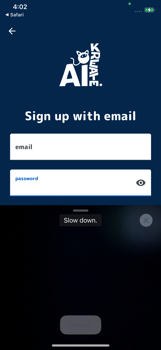


You are present with a screenshot of an iOS app. I want you to parse the screenshot to check if it's a log-in page.
1. Run OCR to parse the image
2. Parse the image and establish an axis based on pixel information. Please answer below questions using this axis where top-left of this image is (0,0).
3. Check the features of this image to decide if it's a log-in page.
4. If it's a login page, perform steps 5 to 7; if not, jump to step 8
5. Check if there is a place where users are supposed to put username.
6. Check if there is a place where users are supposed to put password.
7. Output  Location should be in this format: {x0, y0, x1, y1} as described in draw_coordinates_tool  representing the coordinates of the 4 corners of the rectangle. If there is no username and/or password field, don't include the respective location field.
8. Randomly pick an element that is likely to be tappable, and output the location of that element.





name: "draw_coordinates_on_image"
args {
  fields {
    key: "fields"
    value {
      list_value {
        values {
          struct_value {
            fields {
              key: "coordinates"
              value {
                struct_value {
                  fields {
                    key: "x0"
                    value {
                      number_value: 138.0
                    }
                  }
                  fields {
                    key: "x1"
                    value {
                      number_value: 893.0
                    }
                  }
                  fields {
                    key: "y0"
                    value {
                      number_value: 385.0
                    }
                  }
                  fields {
                    key: "y1"
                    value {
                      number_value: 443.0
                    }
                  }
                }
              }
            }
            fields {
     

In [14]:

# Prepare contents
prompt = """
You are present with a screenshot of an iOS app. I want you to parse the screenshot to check if it's a log-in page.
1. Run OCR to parse the image
2. Parse the image and establish an axis based on pixel information. Please answer below questions using this axis where top-left of this image is (0,0).
3. Check the features of this image to decide if it's a log-in page.
4. If it's a login page, perform steps 5 to 7; if not, jump to step 8
5. Check if there is a place where users are supposed to put username.
6. Check if there is a place where users are supposed to put password.
7. Output  Location should be in this format: {x0, y0, x1, y1} as described in draw_coordinates_tool  representing the coordinates of the 4 corners of the rectangle. If there is no username and/or password field, don't include the respective location field.
8. Randomly pick an element that is likely to be tappable, and output the location of that element.


"""
contents = [image, prompt]


gemini_response = multimodal_model.generate_content(
    contents,
    tools=[draw_coordinates_tool],
)

# gemini_response = multimodal_model.generate_content(
#     contents
# )



print("-------Prompt--------")
print_multimodal_prompt(contents)

gemini_response.candidates[0].content.parts[0].function_call
# response.candidates[0].content.parts[0].text

### Unpack the json

In [18]:
import json
def unpack_response(response):
    output = {}
    function_call = {}
    for key, value in response.candidates[0].content.parts[0].to_dict().items():
        function_call[key] = value
    output["tool_calls"] = [function_call["function_call"]]
    output["tool_calls"][0]["arguments"] = output["tool_calls"][0].pop("args")
    return json.dumps(output)

response = unpack_response(gemini_response)

In [37]:
json.loads(response)["tool_calls"][0]["arguments"]["fields"]

[{'type': 'email',
  'coordinates': {'x1': 893.0, 'x0': 138.0, 'y0': 385.0, 'y1': 443.0}},
 {'coordinates': {'x1': 892.0, 'y0': 460.0, 'x0': 137.0, 'y1': 518.0},
  'type': 'password'}]

### Generate text from text & image(s)


## Function Call

In [19]:
import json
import json
from PIL import Image as PIL_Image
from PIL import ImageDraw as PIL_ImageDraw
import matplotlib.pyplot as plt
import time

def draw_coordinates_on_image_func(image_path, coordinates_dict, name="Region", output_path="./image/output_image.jpg"):
    """
    Draws coordinates onto an image.

    Args:
        image_path (str): Path to the input image.
        coordinates_dict (dict): A dictionary containing coordinates in the format {'x0': ..., 'y0': ..., 'x1': ..., 'y1': ...}
        name (str, optional): Name or label to associate with the coordinates. Defaults to "Region".
        output_path (str, optional): Path to save the modified image. Defaults to "output_image.jpg". 
    """
    
    # Load image
    img = PIL_Image.open(image_path)

    # Extract coordinates 
    x0 = coordinates_dict['x0']
    y0 = coordinates_dict['y0']
    x1 = coordinates_dict['x1']
    y1 = coordinates_dict['y1']

    # Drawing
    draw = PIL_ImageDraw.Draw(img)
    draw.rectangle([(x0, y0), (x1, y1)], outline='red', width=5)  
    draw.text((x0, y0 - 15), name, fill='red')

    # Display the image
    plt.figure(figsize=(25, 20))
    plt.imshow(img)
    plt.axis('on')
    plt.show()

# Example usage
for i in range(len(json_unpacked)):
    print(f"Cordinates of ^^^^^^^^^^^^^^^^^^ {json_unpacked[i]['type']} ^^^^^^^^^^^^^^^^^^")
    print(f"Cordinates of ^^^^^^^^^^^^^^^^^^ {json_unpacked[i]['coordinates']} ^^^^^^^^^^^^^^^^^^")
    
    draw_coordinates_on_image_func(image_path, json_unpacked[i]["coordinates"], json_unpacked[i]["type"])


NameError: name 'json_unpacked' is not defined